# Dry Bean Classification: Machine Learning Project

This notebook covers the full ML workflow for the UCI Dry Bean Dataset.  
We will load, preprocess, train (Random Forest, SVM, KNN), evaluate, and save all results.


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv


## Data Loading
Load the dataset from the Excel file.


In [6]:
# Use your absolute path here:
df = pd.read_excel(r'c:\Users\akhda\Desktop\dry_bean_ml_project\data\Dry_Bean_Dataset.xlsx')
df.head()


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


## Data Preprocessing

We encode the target, scale features, and split into train/test sets (80/20).


In [7]:
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Model Training

We will train Random Forest, SVM (RBF), and KNN (with best k).


In [8]:
# Ensure folders exist for saving
os.makedirs('../models', exist_ok=True)

# 1. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
joblib.dump(rf, '../models/random_forest_model.pkl')

# 2. SVM (RBF kernel)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
joblib.dump(svm, '../models/svm_model.pkl')

# 3. KNN (search for best k)
best_k, best_acc = 3, 0
for k in range(3, 16, 2):
    knn_tmp = KNeighborsClassifier(n_neighbors=k)
    knn_tmp.fit(X_train_scaled, y_train)
    acc = accuracy_score(y_test, knn_tmp.predict(X_test_scaled))
    if acc > best_acc:
        best_k, best_acc = k, acc

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)
joblib.dump(knn, '../models/knn_model.pkl')
print(f"Best K for KNN: {best_k}")


Best K for KNN: 13


In [9]:
def eval_and_save(model, model_name):
    # Directories for saving
    reports_dir = '../results/classification_reports'
    cm_dir = '../results/confusion_matrices'
    os.makedirs(reports_dir, exist_ok=True)
    os.makedirs(cm_dir, exist_ok=True)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Classification report
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    with open(f'{reports_dir}/{model_name}_report.txt', 'w') as f:
        f.write(report)
    
    # Confusion matrix plot (and display inline)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name.replace("_", " ").title()} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{cm_dir}/{model_name}_cm.png')
    plt.show()
    
    # Accuracy
    return accuracy_score(y_test, y_pred), report


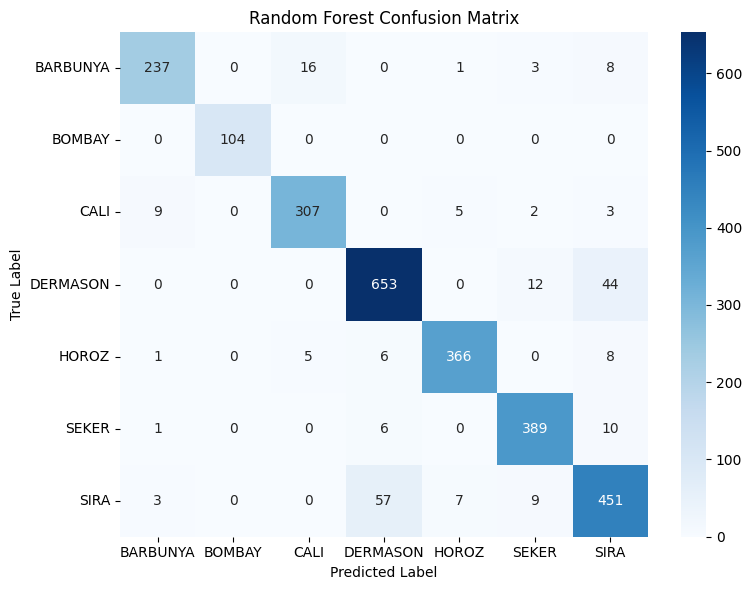

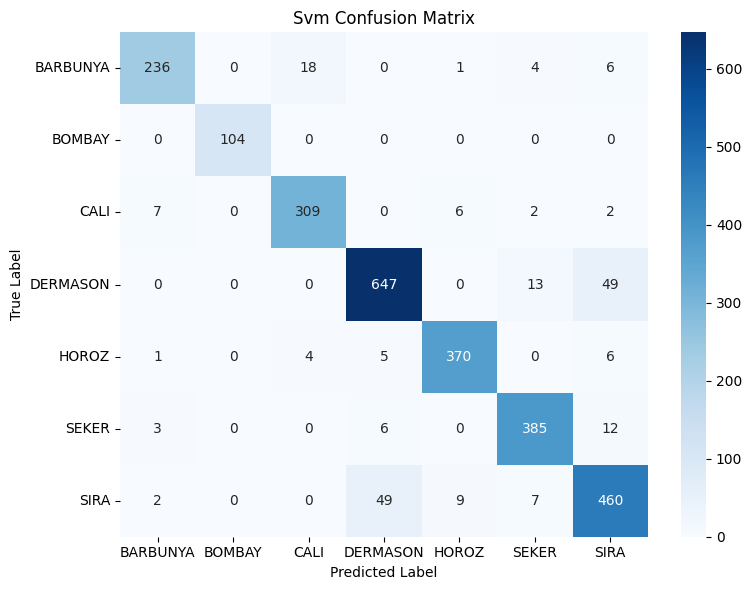

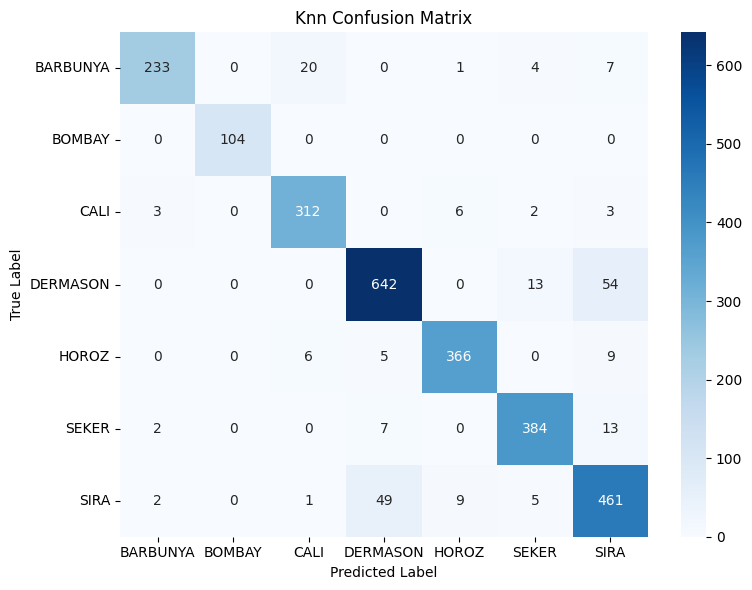

In [10]:
acc_rf, rep_rf = eval_and_save(rf, 'random_forest')
acc_svm, rep_svm = eval_and_save(svm, 'svm')
acc_knn, rep_knn = eval_and_save(knn, 'knn')


In [11]:
# Save accuracy scores to CSV
acc_table = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'KNN'],
    'Accuracy': [acc_rf, acc_svm, acc_knn]
})

acc_table.to_csv('../results/accuracy_scores.csv', index=False)
acc_table


,Model,Accuracy
0,Random Forest,0.920676
1,SVM,0.922145
2,KNN,0.918840


## Results

- All model files, reports, confusion matrices, and accuracy comparison are saved in the project folders.
- Random Forest, SVM, and KNN all achieved good performance; see the accuracy table above.

---

## Conclusion

This notebook demonstrated a full machine learning workflow for the Dry Bean Dataset, including preprocessing, model training, evaluation, and exporting results for reproducibility.
